In [1]:
# Mounting Google Drive
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import random
import matplotlib.pyplot as plt
from matplotlib import axis
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from imblearn.pipeline import Pipeline
from sklearn.datasets import make_blobs
from sklearn.datasets import make_regression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import RandomOverSampler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
!pip install category_encoders
from sklearn.compose import ColumnTransformer
from category_encoders import TargetEncoder
from category_encoders import CountEncoder
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import classification_report


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.2/81.2 kB 4.6 MB/s eta 0:00:00


# Import Data

## Data Dictionary <br>
•	ip: ip address of click. <br>
•	app: app id for marketing. <br>
•	device: device type id of user mobile phone (e.g., iphone 6 plus, iphone 7, huawei mate 7, etc.) <br>
•	os: os version id of user mobile phone <br>
•	channel: channel id of mobile ad publisher <br>
•	click_time: timestamp of click (UTC) <br>
•	attributed_time: if user download the app for after clicking an ad, this is the time of the app download <br>
•	is_attributed: the target that is to be predicted, indicating the app was downloaded <br>
Note that ip, app, device, os, and channel are encoded. <br>
The test data is similar, with the following differences: <br>
•	click_id: reference for making predictions <br>
•	is_attributed: not included <br>

* Note: stratify = meaning equal distribution


Statistical Data Types
- Numerical
    - Continuous
        - ip
        - click_time
        - attributed_time
    - Discrete
        - app
        - device
        - os
        - channel

In [4]:
df_train = pd.read_csv(f'/content/drive/MyDrive/Portfolio Projects Mark/talkingdata-adtracking-fraud-detection/train.csv', nrows = 1000000)
df_test = pd.read_csv(f'/content/drive/MyDrive/Portfolio Projects Mark/talkingdata-adtracking-fraud-detection/test.csv', nrows = 1000000)
df_sample = pd.read_csv(f'/content/drive/MyDrive/Portfolio Projects Mark/talkingdata-adtracking-fraud-detection/train_sample.csv')

In [5]:
sample = df_train.sample(n=50000,random_state=42)

In [6]:
df_sample.head(10)

,ip,app,device,os,channel,click_time,attributed_time,is_attributed
0,87540,12,1,13,497,2017-11-07 09:30:38,NaN,0
1,105560,25,1,17,259,2017-11-07 13:40:27,NaN,0
2,101424,12,1,19,212,2017-11-07 18:05:24,NaN,0
3,94584,13,1,13,477,2017-11-07 04:58:08,NaN,0
4,68413,12,1,1,178,2017-11-09 09:00:09,NaN,0
5,93663,3,1,17,115,2017-11-09 01:22:13,NaN,0
6,17059,1,1,17,135,2017-11-09 01:17:58,NaN,0
7,121505,9,1,25,442,2017-11-07 10:01:53,NaN,0
8,192967,2,2,22,364,2017-11-08 09:35:17,NaN,0
9,143636,3,1,19,135,2017-11-08 12:35:26,NaN,0


In [7]:
df_test.head(10)

,click_id,ip,app,device,os,channel,click_time
0,0,5744,9,1,3,107,2017-11-10 04:00:00
1,1,119901,9,1,3,466,2017-11-10 04:00:00
2,2,72287,21,1,19,128,2017-11-10 04:00:00
3,3,78477,15,1,13,111,2017-11-10 04:00:00
4,4,123080,12,1,13,328,2017-11-10 04:00:00
5,5,110769,18,1,13,107,2017-11-10 04:00:00
6,6,12540,3,1,1,137,2017-11-10 04:00:00
7,7,88637,27,1,19,153,2017-11-10 04:00:00
8,9,14932,18,1,10,107,2017-11-10 04:00:00
9,8,123701,12,1,53,424,2017-11-10 04:00:00


# EDA

## Compare between df_sample and df_train

In [8]:
df_sample['is_attributed'].value_counts(normalize=True)

0    0.99773
1    0.00227
Name: is_attributed, dtype: float64

In [9]:
df_train['is_attributed'].value_counts(normalize=True)

0    0.998307
1    0.001693
Name: is_attributed, dtype: float64

## Sample Training Data

In [10]:
df_sample.describe()

,ip,app,device,os,channel,is_attributed
count,100000.000000,100000.00000,100000.000000,100000.000000,100000.000000,100000.000000
mean,91255.879670,12.04788,21.771250,22.818280,268.832460,0.002270
std,69835.553661,14.94150,259.667767,55.943136,129.724248,0.047591
min,9.000000,1.00000,0.000000,0.000000,3.000000,0.000000
25%,40552.000000,3.00000,1.000000,13.000000,145.000000,0.000000
50%,79827.000000,12.00000,1.000000,18.000000,258.000000,0.000000
75%,118252.000000,15.00000,1.000000,19.000000,379.000000,0.000000
max,364757.000000,551.00000,3867.000000,866.000000,498.000000,1.000000


In [11]:
df_sample.dtypes

ip                  int64
app                 int64
device              int64
os                  int64
channel             int64
click_time         object
attributed_time    object
is_attributed       int64
dtype: object

In [12]:
df_sample.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 8 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   ip               100000 non-null  int64 
 1   app              100000 non-null  int64 
 2   device           100000 non-null  int64 
 3   os               100000 non-null  int64 
 4   channel          100000 non-null  int64 
 5   click_time       100000 non-null  object
 6   attributed_time  227 non-null     object
 7   is_attributed    100000 non-null  int64 
dtypes: int64(6), object(2)
memory usage: 6.1+ MB


In [13]:
df_sample.shape

(100000, 8)

In [14]:
df_sample.isnull().sum()

ip                     0
app                    0
device                 0
os                     0
channel                0
click_time             0
attributed_time    99773
is_attributed          0
dtype: int64

In [15]:
print('Number of Unique App:', len(df_sample['app'].unique().flatten()))
print('Number of Unique device:',len(df_sample['device'].unique().flatten()))
print('Number of unique IP:', len(df_sample['ip'].unique().flatten()))
print('Number of unique OS:', len(df_sample['os'].unique().flatten()))
print('Number of unique channel:', len(df_sample['channel'].unique().flatten()))

Number of Unique App: 161
Number of Unique device: 100
Number of unique IP: 34857
Number of unique OS: 130
Number of unique channel: 161


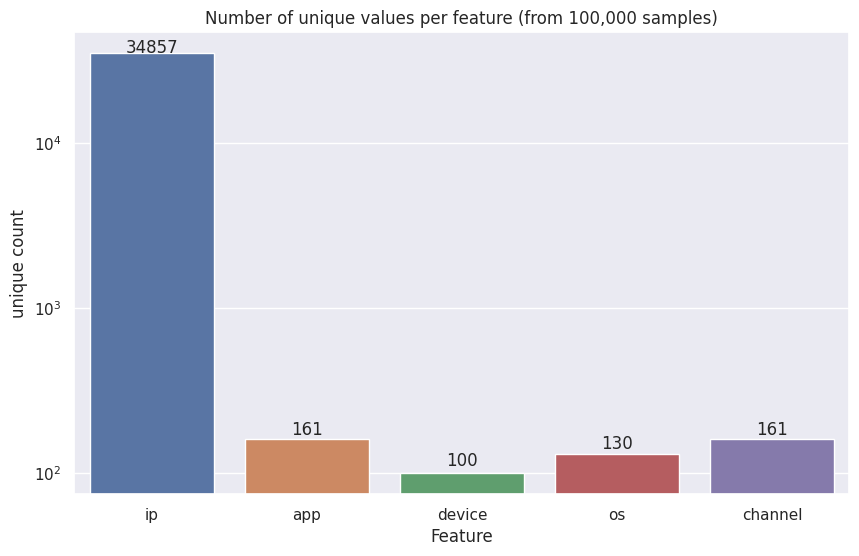

In [16]:
plt.figure(figsize=(10, 6))
cols = ['ip', 'app', 'device', 'os', 'channel']
uniques = [len(df_sample[col].unique()) for col in cols]
sns.set(font_scale=1)
ax = sns.barplot(x=cols, y=uniques, log = True)
ax.set(xlabel='Feature', ylabel='unique count', title='Number of unique values per feature (from 100,000 samples)')
for p, uniq in zip(ax.patches, uniques):
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 10,
            uniq,
            ha="center") 

In [17]:
df_sample_corr= df_sample.corr()
df_sample_corr

<ipython-input-17-c8bcc04561ac>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  df_sample_corr= df_sample.corr()


,ip,app,device,os,channel,is_attributed
ip,1.000000,0.010400,-0.001499,-0.000470,0.007563,0.054955
app,0.010400,1.000000,0.248376,0.247160,-0.028238,0.064426
device,-0.001499,0.248376,1.000000,0.924456,-0.035398,-0.000695
os,-0.000470,0.247160,0.924456,1.000000,-0.033175,0.006183
channel,0.007563,-0.028238,-0.035398,-0.033175,1.000000,-0.023336
is_attributed,0.054955,0.064426,-0.000695,0.006183,-0.023336,1.000000


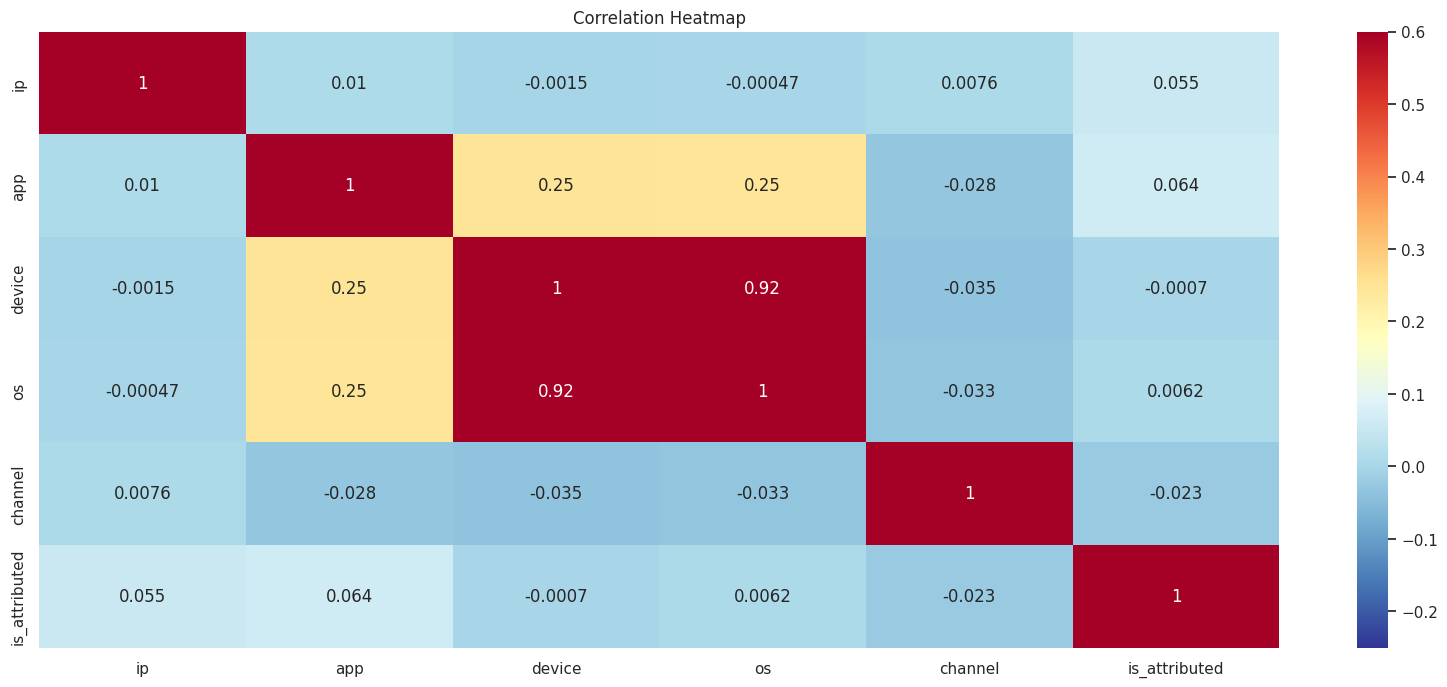

In [18]:
plt.figure(figsize = (20, 8))

# Heatmap of correlations
sns.heatmap(df_sample_corr, cmap = plt.cm.RdYlBu_r, vmin = -0.25, annot = True, vmax = 0.6)
plt.title('Correlation Heatmap');

### Ip column

In [19]:
df_sample['ip'].nunique()

34857

In [20]:
# Top 10 Ips
df_sample['ip'].value_counts().head(10)

5348      669
5314      616
73487     439
73516     399
53454     280
114276    219
26995     218
95766     205
17149     186
100275    173
Name: ip, dtype: int64

In [21]:
#group all count_ip = 10 and name them 'other'
threshold = 50 

grouped_ip = df_sample.groupby('ip').size().reset_index(name='count_ip')
#sort value by count

grouped_ip=grouped_ip.sort_values('count_ip', ascending = False)

# group all products with count less than threshold as 'other'
other_count = grouped_ip.loc[grouped_ip['count_ip'] < threshold, 'count_ip'].sum()
grouped_ip = grouped_ip.loc[grouped_ip['count_ip'] >= threshold]
grouped_ip = pd.concat([grouped_ip, pd.DataFrame({'ip': ['other'], 'count_ip': [other_count]})]).reset_index(drop=True)

grouped_ip.head(10)
# # group all products with count less than threshold as 'other'
# other_count = grouped_ip[grouped_ip < threshold].sum()
# grouped_ip = grouped_ip[grouped_ip >= threshold]
# grouped_ip['other'] = other_count

,ip,count_ip
0,5348,669
1,5314,616
2,73487,439
3,73516,399
4,53454,280
5,114276,219
6,26995,218
7,95766,205
8,17149,186
9,100275,173


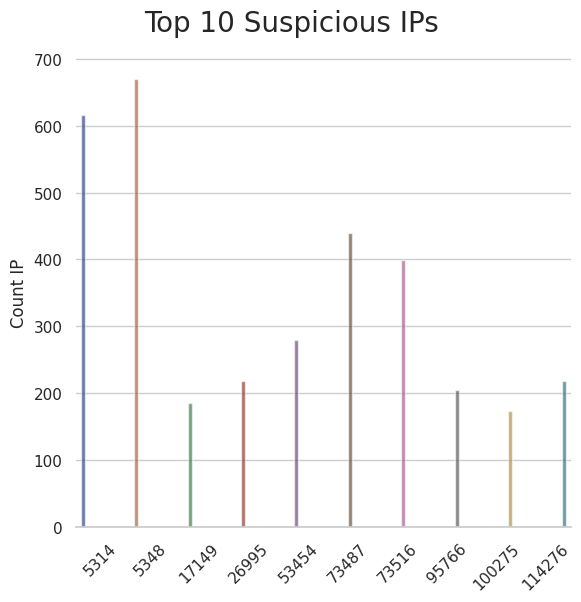

In [22]:
sns.set_theme(style="whitegrid")

# Draw a nested barplot by species and sex
g = sns.catplot(
    data=grouped_ip.head(10), kind="bar",
    x="ip", y="count_ip", hue="ip", palette="dark", alpha=.6, height=6
)
g.despine(left=True)
g.set_axis_labels("", "Count IP")

g.fig.subplots_adjust(top=0.9)
g.fig.suptitle("Top 10 Suspicious IPs",
                  fontsize=20, fontdict={"weight": "bold"})
plt.xticks(rotation=45);

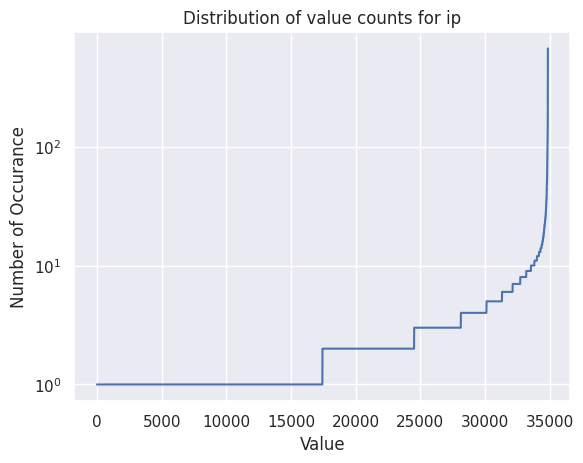

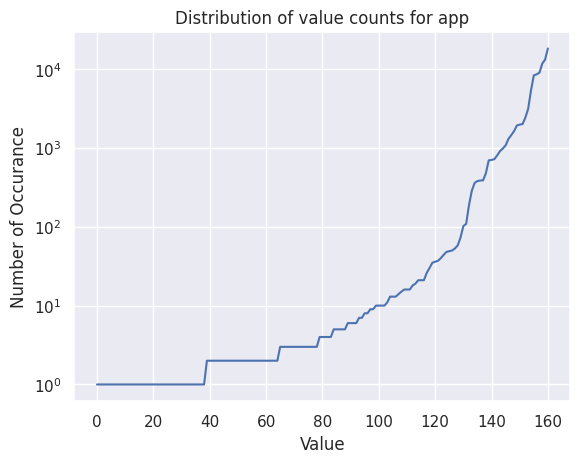

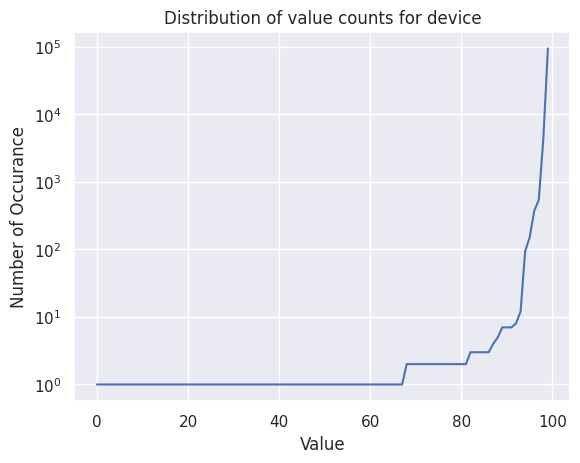

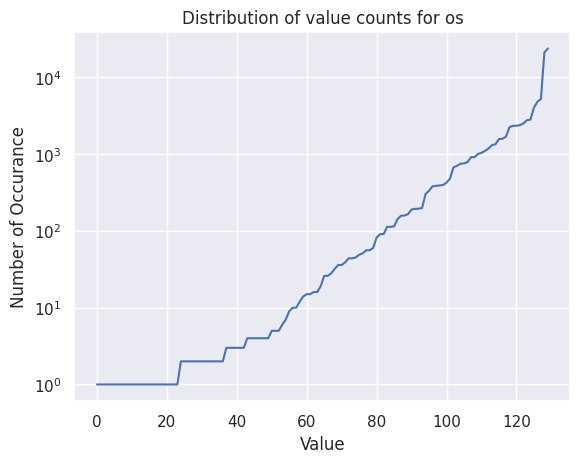

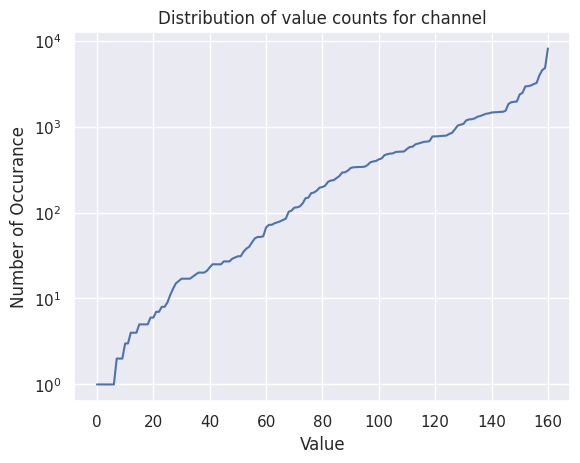

In [ ]:
ip_unique = df_sample['ip'].unique()
count_ip = df_sample['ip'].value_counts()
sort_count = np.sort(count_ip.values)
for col, uniq in zip(cols, uniques):
  count_value = df_sample[col].value_counts()
  sort_count = np.sort(count_value.values)
  fig = plt.figure()
  ax = fig.add_subplot(111)
  line = ax.plot(sort_count)
  ax.set_yscale('log')
  plt.title("Distribution of value counts for {}".format(col))
  plt.ylabel('Number of Occurance')
  plt.xlabel('Value')
  plt.show()

### App Columns

In [23]:
df_sample['app'].nunique()

161

In [24]:
df_sample['app'].value_counts().head(10).reset_index()

,index,app
0,3,18279
1,12,13198
2,2,11737
3,9,8992
4,15,8595
5,18,8315
6,14,5359
7,1,3135
8,13,2422
9,8,2004


### Device Column

In [39]:
device = pd.DataFrame(df_sample['device'].value_counts())
device = device.rename(columns=({'device':'count'}))
device = device.reset_index()
device = device.rename(columns={'index':'device'})
# Change type of Device column
device['device'] = device['device'].apply(lambda x:str(x))

In [40]:
df_sample['device'].value_counts().head(10)

1       94338
2        4345
0         541
3032      371
3543      151
3866       93
59         12
6           8
16          7
40          7
Name: device, dtype: int64

In [41]:
device=device.head(10)

<Figure size 640x480 with 0 Axes>

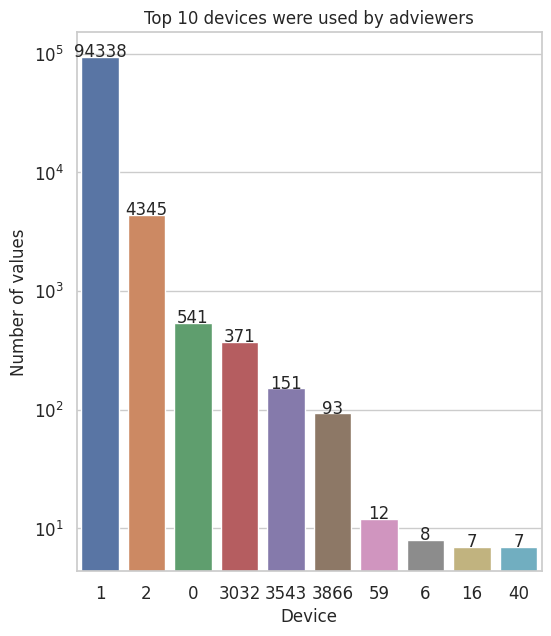

In [44]:
def addlabels(x,y):
    for i in range(len(x)):
        plt.text(i, y[i], y[i], ha = 'center')
plt.figure()
fig, ax = plt.subplots(figsize=(6,7))
x = device['device']
y = device['count']
addlabels(x, y)
sns.barplot(ax=ax, x=x, y=y)
ax.set_yscale('log')
plt.ylabel('Number of values', fontsize=12)
plt.xlabel('Device', fontsize=12)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.title('Top 10 devices were used by adviewers')
plt.show();

### Channel

In [32]:
df_sample['channel'].value_counts().head(10)

280    8114
245    4802
107    4543
477    3960
134    3224
259    3130
265    3013
153    2954
178    2936
121    2472
Name: channel, dtype: int64

In [33]:
df_sample['channel'].value_counts().tail(10)

410    2
15     2
455    2
498    1
451    1
114    1
474    1
261    1
465    1
4      1
Name: channel, dtype: int64

In [ ]:
def addlabels(x,y):
    for i in range(len(x)):
        plt.text(i, y[i], y[i], ha = 'center')
plt.figure()
fig, ax = plt.subplots(figsize=(6,7))
x = device['device']
y = df_sample['device'].value_counts().head(10)
addlabels(x, y)
sns.barplot(ax=ax, x=x, y=y)
ax.set_yscale('log')
plt.ylabel('Number of values', fontsize=12)
plt.xlabel('Device', fontsize=12)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.title('Top 5 devices were used')
plt.show();

In [ ]:
sns.barplot(data = df_sample, x)

### Click time


In [ ]:
df_sample.head(10)

,ip,app,device,os,channel,click_time,attributed_time,is_attributed
0,87540,12,1,13,497,2017-11-07 09:30:38,NaN,0
1,105560,25,1,17,259,2017-11-07 13:40:27,NaN,0
2,101424,12,1,19,212,2017-11-07 18:05:24,NaN,0
3,94584,13,1,13,477,2017-11-07 04:58:08,NaN,0
4,68413,12,1,1,178,2017-11-09 09:00:09,NaN,0
5,93663,3,1,17,115,2017-11-09 01:22:13,NaN,0
6,17059,1,1,17,135,2017-11-09 01:17:58,NaN,0
7,121505,9,1,25,442,2017-11-07 10:01:53,NaN,0
8,192967,2,2,22,364,2017-11-08 09:35:17,NaN,0
9,143636,3,1,19,135,2017-11-08 12:35:26,NaN,0


#### Note: Potential Blacklist Ip (click but no download - attributed time = NaN)

In [ ]:
df_ad_ip=pd.DataFrame(df_sample.groupby('ip').count()[['click_time','attributed_time']])
df_ad_ip=df_ad_ip.sort_values(by=['click_time'], ascending=False)
#df_ad_ip
df_ad_ip[df_ad_ip['attributed_time']<1].head(10)

,click_time,attributed_time
ip,,
73487,439,0
73516,399,0
53454,280,0
114276,219,0
26995,218,0
95766,205,0
17149,186,0
100275,173,0
105475,167,0


#### Note: Potential Blacklist Device

In [ ]:
df_ad_device=pd.DataFrame(df_sample.groupby('device').count()[['click_time','attributed_time']])
df_ad_device=df_ad_device.sort_values(by=['click_time'], ascending=False)
top_10=df_ad_device[df_ad_device['attributed_time']<1].head(10)

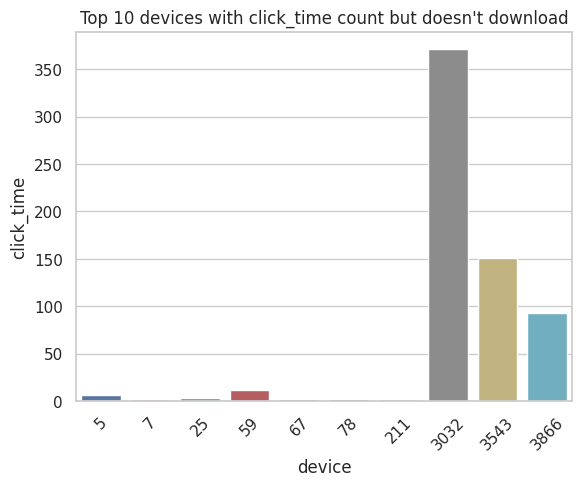

In [ ]:
sns.barplot(x=top_10.index, y=top_10['click_time'] )
plt.xticks(rotation = 45)
plt.title("Top 10 devices with click_time count but doesn't download")
plt.show()

#### Note: Potential Blacklist Channel

In [ ]:
df_ad_channel=pd.DataFrame(df_sample.groupby('channel').count()[['click_time','attributed_time']])
df_ad_channel=df_ad_channel.sort_values(by=['click_time'], ascending=False)
df_ad_channel[df_ad_channel['attributed_time']<1].head(20)

,click_time,attributed_time
channel,,
245,4802,0
477,3960,0
259,3130,0
153,2954,0
178,2936,0
205,2369,0
459,1921,0
128,1486,0
135,1473,0


### Is_atrributed

In [ ]:
df_sample["is_attributed"].value_counts(normalize = True)

0    0.99773
1    0.00227
Name: is_attributed, dtype: float64

<Figure size 640x480 with 0 Axes>

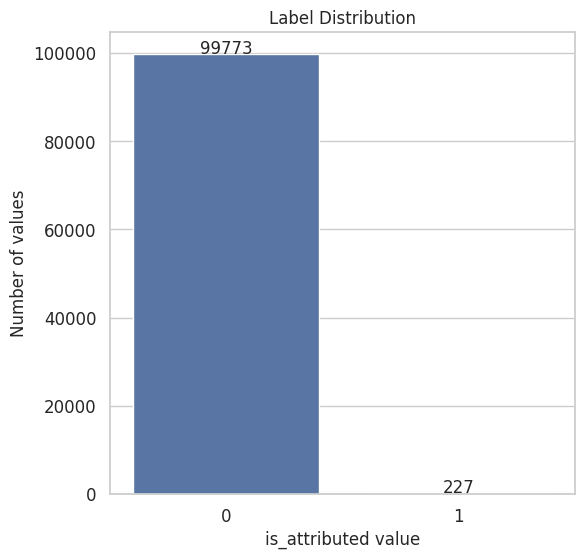

In [ ]:
def addlabels(x,y):
    for i in range(len(x)):
        plt.text(i, y[i], y[i], ha = 'center')
 
plt.figure();
fig, ax = plt.subplots(figsize=(6,6))
x = df_sample['is_attributed'].value_counts().index.values
y = df_sample["is_attributed"].value_counts().values
addlabels(x, y)

sns.barplot(ax=ax, x=x, y=y)
plt.ylabel('Number of values', fontsize=12)
plt.xlabel('is_attributed value', fontsize=12)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.title('Label Distribution')
plt.show();

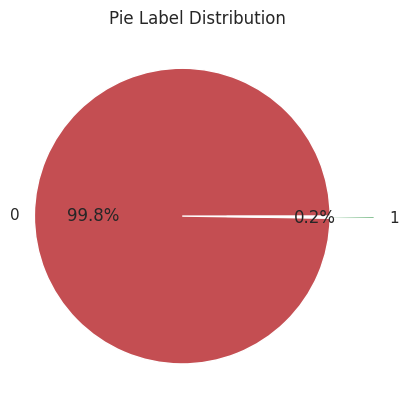

In [ ]:
import matplotlib.pyplot as plt
# Pie chart, where the slices will be ordered and plotted counter-clockwise:
labels = df_sample['is_attributed'].value_counts().index.values
sizes = df_sample["is_attributed"].value_counts().values
fig1, ax1 = plt.subplots()
explode = [0.1, 0.2]
ax1.pie(sizes, labels=labels, autopct='%1.1f%%', colors=['r', 'g'], explode=explode)
plt.title("Pie Label Distribution")
plt.show()

<ipython-input-233-9bd435e57866>:14: UserWarning: 

The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`.
Setting `bw_method=0.5`, but please see the docs for the new parameters
and update your code. This will become an error in seaborn v0.13.0.

  sns.kdeplot(t1[feature], bw=0.5,label="is_attributed = 1")
<ipython-input-233-9bd435e57866>:15: UserWarning: 

The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`.
Setting `bw_method=0.5`, but please see the docs for the new parameters
and update your code. This will become an error in seaborn v0.13.0.

  sns.kdeplot(t0[feature], bw=0.5,label="is_attributed = 0")
<ipython-input-233-9bd435e57866>:14: UserWarning: 

The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`.
Setting `bw_method=0.5`, but please see the docs for the new parameters
and update your code. This will become an error in seaborn v0.13.0.

  sns.kdeplot(t1[feature], bw=0.5,label="is_attributed = 1")
<ipython-input-2

<Figure size 640x480 with 0 Axes>

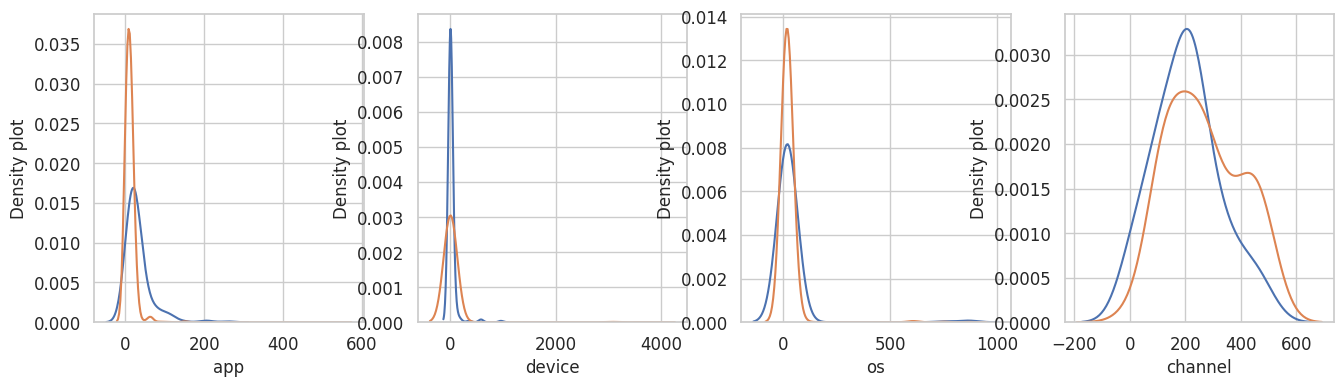

In [ ]:
var = ['app','device','os','channel']

i = 0
t1 = df_sample.loc[df_sample['is_attributed'] != 0]
t0 = df_sample.loc[df_sample['is_attributed'] == 0]

sns.set_style('whitegrid')
plt.figure()
fig, ax = plt.subplots(1,4,figsize=(16,4))

for feature in var:
    i += 1
    plt.subplot(1,4,i)
    sns.kdeplot(t1[feature], bw=0.5,label="is_attributed = 1")
    sns.kdeplot(t0[feature], bw=0.5,label="is_attributed = 0")
    plt.ylabel('Density plot', fontsize=12)
    plt.xlabel(feature, fontsize=12)
    locs, labels = plt.xticks()
    plt.tick_params(axis='both', which='major', labelsize=12)
plt.show();

# Machine Learning

## Feature Engineer

In [ ]:
df_sample['click_time'] = pd.to_datetime(df_sample['click_time'], errors='coerce')

In [ ]:
# Add new columns for timestamp features day, hour, minute, and second
df_train_sample = df_sample.copy()
#Change Data Type
df_train_sample['ip']=df_train_sample['ip'].astype('category')
df_train_sample['app']=df_train_sample['app'].astype('category')
df_train_sample['device']=df_train_sample['device'].astype('category')
df_train_sample['os']=df_train_sample['os'].astype('category')
df_train_sample['channel']=df_train_sample['channel'].astype('category')
df_train_sample['click_time']=pd.to_datetime(df_train_sample['click_time'])
df_train_sample['attributed_time']=pd.to_datetime(df_train_sample['attributed_time'])
df_train_sample['day_of_week']=df_train_sample['click_time'].dt.dayofweek.astype('category')
df_train_sample['day'] = df_sample['click_time'].dt.day.astype('category')
df_train_sample['hour'] = df_sample['click_time'].dt.hour.astype('category')
df_train_sample['minute'] = df_sample['click_time'].dt.minute.astype('category')
df_train_sample['second'] = df_sample['click_time'].dt.second.astype('category')

In [ ]:
df_train_sample.dtypes

ip                       category
app                      category
device                   category
os                       category
channel                  category
click_time         datetime64[ns]
attributed_time    datetime64[ns]
is_attributed               int64
day_of_week              category
day                      category
hour                     category
minute                   category
second                   category
dtype: object

In [ ]:
df_train_sample['day'].unique()

[7, 9, 8, 6]
Categories (4, int64): [6, 7, 8, 9]

In [ ]:
df_train_sample['day_of_week'].unique()

[1, 3, 2, 0]
Categories (4, int64): [0, 1, 2, 3]

In [ ]:
df_train_sample

,ip,app,device,os,channel,click_time,attributed_time,is_attributed,day_of_week,day,hour,minute,second
0,87540,12,1,13,497,2017-11-07 09:30:38,NaT,0,1,7,9,30,38
1,105560,25,1,17,259,2017-11-07 13:40:27,NaT,0,1,7,13,40,27
2,101424,12,1,19,212,2017-11-07 18:05:24,NaT,0,1,7,18,5,24
3,94584,13,1,13,477,2017-11-07 04:58:08,NaT,0,1,7,4,58,8
4,68413,12,1,1,178,2017-11-09 09:00:09,NaT,0,3,9,9,0,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,124883,11,1,19,122,2017-11-09 13:25:41,NaT,0,3,9,13,25,41
99996,85150,9,1,13,244,2017-11-07 11:25:43,NaT,0,1,7,11,25,43
99997,18839,3,1,13,19,2017-11-08 11:38:42,NaT,0,2,8,11,38,42
99998,114276,15,1,12,245,2017-11-08 17:55:21,NaT,0,2,8,17,55,21


## Label Encoder

In [ ]:
X = df_train_sample.drop(['is_attributed','attributed_time','click_time'],axis=1)
y = df_train_sample['is_attributed']
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 10 columns):
 #   Column       Non-Null Count   Dtype   
---  ------       --------------   -----   
 0   ip           100000 non-null  category
 1   app          100000 non-null  category
 2   device       100000 non-null  category
 3   os           100000 non-null  category
 4   channel      100000 non-null  category
 5   day_of_week  100000 non-null  category
 6   day          100000 non-null  category
 7   hour         100000 non-null  category
 8   minute       100000 non-null  category
 9   second       100000 non-null  category
dtypes: category(10)
memory usage: 2.8 MB


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.25, stratify=y,random_state=42)

In [ ]:
X_train.shape

(75000, 10)

In [ ]:
X_test.shape

(25000, 10)

In [ ]:
y_train.value_counts(normalize = True)

0    0.997733
1    0.002267
Name: is_attributed, dtype: float64

In [ ]:
y_test.value_counts(normalize = True)

0    0.99772
1    0.00228
Name: is_attributed, dtype: float64

In [ ]:
X_train.columns

Index(['ip', 'app', 'device', 'os', 'channel', 'day_of_week', 'day', 'hour',
       'minute', 'second'],
      dtype='object')

In [ ]:
cat_feature = ['ip', 'app', 'device', 'os', 'channel', 'day_of_week', 'day', 'hour', 'minute',
       'second']

In [ ]:
preprocessor = ColumnTransformer(transformers = [
    ('enc_cat',TargetEncoder(),cat_feature)
], remainder = 'passthrough')

In [ ]:
lr = Pipeline(steps=[
    ('prc',preprocessor),
    ('ros',RandomOverSampler()),
    ('Lrm',LogisticRegression())
])

In [ ]:
lr.fit(X_train,y_train)

Pipeline(steps=[('prc',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('enc_cat', TargetEncoder(),
                                                  ['ip', 'app', 'device', 'os',
                                                   'channel', 'day_of_week',
                                                   'day', 'hour', 'minute',
                                                   'second'])])),
                ('ros', RandomOverSampler()), ('Lrm', LogisticRegression())])

In [ ]:
y_pred = lr.predict(X_test)

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.99      1.00     24943
           1       0.19      0.67      0.29        57

    accuracy                           0.99     25000
   macro avg       0.59      0.83      0.64     25000
weighted avg       1.00      0.99      0.99     25000



In [ ]:
features_names = lr.named_steps['prc'].named_transformers_['enc_cat'].get_feature_names_out()

In [ ]:
coef = lr.named_steps['Lrm'].coef_.flatten()

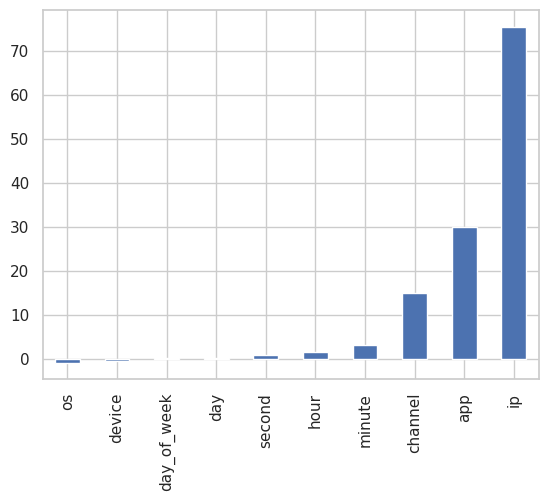

In [ ]:
#model interpretation
pd.Series(coef, index= X.columns).sort_values().plot(kind='bar');

In [ ]:
pd.Series(coef, index=X.columns)

ip             75.582188
app            29.924597
device         -0.340185
os             -0.750749
channel        14.964072
day_of_week     0.319857
day             0.319857
hour            1.678852
minute          3.216652
second          0.917465
dtype: float64

In [ ]:
dt = Pipeline(steps=[
    ('prc',preprocessor),
    ('ros',RandomOverSampler()),
    ('dt',RandomForestClassifier())
])

In [ ]:
dt.fit(X_train,y_train)

Pipeline(steps=[('prc',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('enc_cat', TargetEncoder(),
                                                  ['ip', 'app', 'device', 'os',
                                                   'channel', 'day_of_week',
                                                   'day', 'hour', 'minute',
                                                   'second'])])),
                ('ros', RandomOverSampler()),
                ('dt', RandomForestClassifier())])

In [ ]:
y_pred = dt.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     24943
           1       0.00      0.00      0.00        57

    accuracy                           1.00     25000
   macro avg       0.50      0.50      0.50     25000
weighted avg       1.00      1.00      1.00     25000



In [ ]:
#cross validation 
from sklearn.model_selection import cross_val_score
score= cross_val_score(dt,X,y,cv=5)

In [ ]:
score.mean()

0.9976400000000002

In [ ]:
RandomForestClassifier()

Hyperparameter Tuning for my model

In [ ]:
from sklearn.model_selection import GridSearchCV

In [ ]:
param_grids = {
    "dt__n_estimators":[50,100,150],
    "dt__max_depth":[10,20,30],
    "dt__criterion":['gini','entropy']
}

gs=GridSearchCV(dt, param_grid=param_grids,cv=5,scoring = 'accuracy')

In [ ]:
gs.fit(X,y)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('prc',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('enc_cat',
                                                                         TargetEncoder(),
                                                                         ['ip',
                                                                          'app',
                                                                          'device',
                                                                          'os',
                                                                          'channel',
                                                                          'day_of_week',
                                                                          'day',
                                                                          'hour',
                                                                          'minute',
                                                                          'second'])])),
                                       ('ros', RandomOverSampler()),
                                       ('dt', RandomForestClassifier())]),
             param_grid={'dt__criterion': ['gini', 'entropy'],
                         'dt__max_depth': [10, 20, 30],
                         'dt__n_estimators': [50, 100, 150]},
             scoring='accuracy')

In [ ]:
print('Best HyperParameter: ',gs.best_params_)
print('Best Score: ',gs.best_score_)

Best HyperParameter:  {'dt__criterion': 'gini', 'dt__max_depth': 20, 'dt__n_estimators': 50}
Best Score:  0.9976500000000001


In [ ]:
best_model = gs.best_estimator_
y_pred = best_model.predict(X_test)
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     24943
           1       1.00      1.00      1.00        57

    accuracy                           1.00     25000
   macro avg       1.00      1.00      1.00     25000
weighted avg       1.00      1.00      1.00     25000



In [ ]:
#precision recall curve (for imbalance dataset)
#look at oversampling 
from sklearn.metrics import roc_curve,auc
proba = (lr.predict_proba(X_test)[:,1])
fpr,tpr,thresholds = roc_curve(y_test,proba)

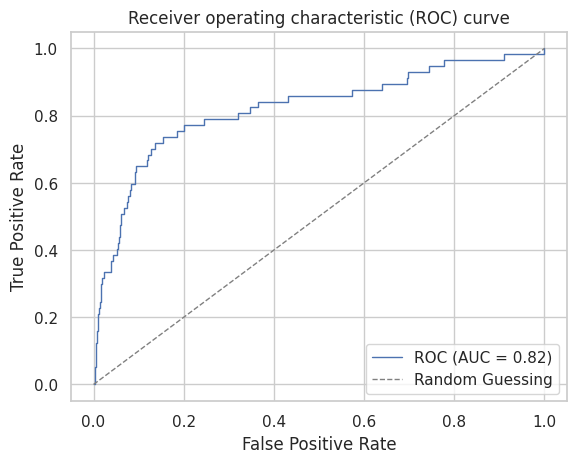

In [ ]:
roc_auc= auc(fpr,tpr)
plt.plot(fpr, tpr, lw=1, label='ROC (AUC = %0.2f)' % (roc_auc))
plt.plot([0, 1], [0, 1], linestyle='--', lw=1, color='gray', label='Random Guessing')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC) curve')
plt.legend(loc="lower right")
plt.show()

In [ ]:
from sklearn.metrics import precision_recall_curve, f1_score
from matplotlib import pyplot

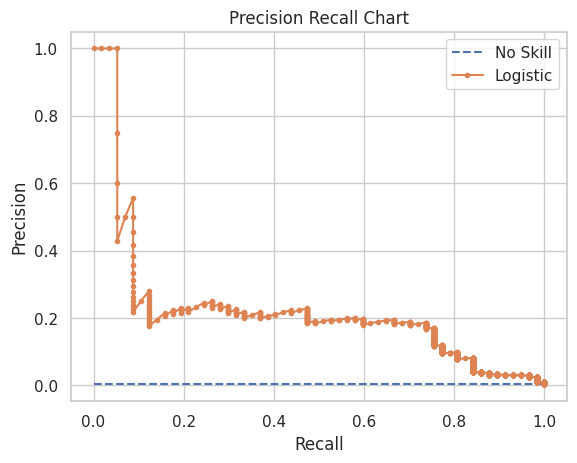

In [ ]:
proba = lr.predict_proba(X_test)[:,1]
lr_precision, lr_recall, _ = precision_recall_curve(y_test, proba)

lr_f1 = f1_score(y_test, y_pred)
lr_auc = auc(lr_recall, lr_precision)
no_skill = len(y_test[y_test==1])/len(y_test)


pyplot.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
pyplot.plot(lr_recall, lr_precision, marker='.', label='Logistic')
# axis labels
pyplot.xlabel('Recall')
pyplot.ylabel('Precision')
# show the legend
pyplot.legend()
# show the plot
plt.title("Precision Recall Chart")
pyplot.show();


In [ ]:
len(y_test[y_test==1])

57

In [ ]:
len(y_test)

25000

### Machine Learning (Potential)

## Decision Tree

In [ ]:
df_train_sample

,ip,app,device,os,channel,click_time,attributed_time,is_attributed,day_of_week,day,hour,minute,second
0,87540,12,1,13,497,2017-11-07 09:30:38,1970-01-01,0,1,7,9,30,38
1,105560,25,1,17,259,2017-11-07 13:40:27,1970-01-01,0,1,7,13,40,27
2,101424,12,1,19,212,2017-11-07 18:05:24,1970-01-01,0,1,7,18,5,24
3,94584,13,1,13,477,2017-11-07 04:58:08,1970-01-01,0,1,7,4,58,8
4,68413,12,1,1,178,2017-11-09 09:00:09,1970-01-01,0,3,9,9,0,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,124883,11,1,19,122,2017-11-09 13:25:41,1970-01-01,0,3,9,13,25,41
99996,85150,9,1,13,244,2017-11-07 11:25:43,1970-01-01,0,1,7,11,25,43
99997,18839,3,1,13,19,2017-11-08 11:38:42,1970-01-01,0,2,8,11,38,42
99998,114276,15,1,12,245,2017-11-08 17:55:21,1970-01-01,0,2,8,17,55,21


In [ ]:
df_training=df_train_sample.copy()
df_training=df_training.drop(['attributed_time','day_of_week','day','hour','minute','second','click_time'], axis=1)
df_training

,ip,app,device,os,channel,is_attributed
0,87540,12,1,13,497,0
1,105560,25,1,17,259,0
2,101424,12,1,19,212,0
3,94584,13,1,13,477,0
4,68413,12,1,1,178,0
...,...,...,...,...,...,...
99995,124883,11,1,19,122,0
99996,85150,9,1,13,244,0
99997,18839,3,1,13,19,0
99998,114276,15,1,12,245,0


In [ ]:
df_training['is_attributed']=df_training['is_attributed'].astype('category')

In [ ]:
df_training.dtypes

ip                  int64
app                 int64
device              int64
os                  int64
channel             int64
is_attributed    category
dtype: object

In [ ]:
df_testing=df_test.drop(['click_id','click_time'], axis=1)
df_testing

,ip,app,device,os,channel
0,5744,9,1,3,107
1,119901,9,1,3,466
2,72287,21,1,19,128
3,78477,15,1,13,111
4,123080,12,1,13,328
...,...,...,...,...,...
999995,53436,18,1,23,376
999996,25714,6,1,13,125
999997,31139,13,1,18,477
999998,114636,18,1,78,439


In [ ]:
target= df_training['is_attributed']
predictors=df_training.drop(['is_attributed'],axis=1)
predictors_train, predictors_test, target_train, target_test=train_test_split(predictors, target, test_size=0.3, random_state=0)
print(predictors_train.shape,predictors_test.shape,target_train.shape, target_test.shape)

(70000, 5) (30000, 5) (70000,) (30000,)


In [ ]:
# Examine the porportion of target variable for training data set
print(target_train.value_counts(normalize=True))

0    0.9979
1    0.0021
Name: is_attributed, dtype: float64


In [ ]:
# Examine the porportion of target variable for testing data set
print(target_test.value_counts(normalize=True))

0    0.997333
1    0.002667
Name: is_attributed, dtype: float64


In [ ]:
# Build a decision tree model on training data with max_depth = 2
model=DecisionTreeClassifier(criterion='entropy',random_state=1, max_depth=2)
model.fit(predictors_train, target_train)
DecisionTreeClassifier(criterion='entropy', max_depth=2, random_state=1)

DecisionTreeClassifier(criterion='entropy', max_depth=2, random_state=1)

[Text(0.5, 0.8333333333333334, 'app <= 18.5\nentropy = 0.022\nsamples = 70000\nvalue = [69853, 147]\nclass = No'),
 Text(0.25, 0.5, 'ip <= 174082.5\nentropy = 0.007\nsamples = 61165\nvalue = [61128, 37]\nclass = No'),
 Text(0.125, 0.16666666666666666, 'entropy = 0.004\nsamples = 53636\nvalue = [53620, 16]\nclass = No'),
 Text(0.375, 0.16666666666666666, 'entropy = 0.028\nsamples = 7529\nvalue = [7508, 21]\nclass = No'),
 Text(0.75, 0.5, 'app <= 19.5\nentropy = 0.097\nsamples = 8835\nvalue = [8725, 110]\nclass = No'),
 Text(0.625, 0.16666666666666666, 'entropy = 0.603\nsamples = 319\nvalue = [272, 47]\nclass = No'),
 Text(0.875, 0.16666666666666666, 'entropy = 0.063\nsamples = 8516\nvalue = [8453, 63]\nclass = No')]

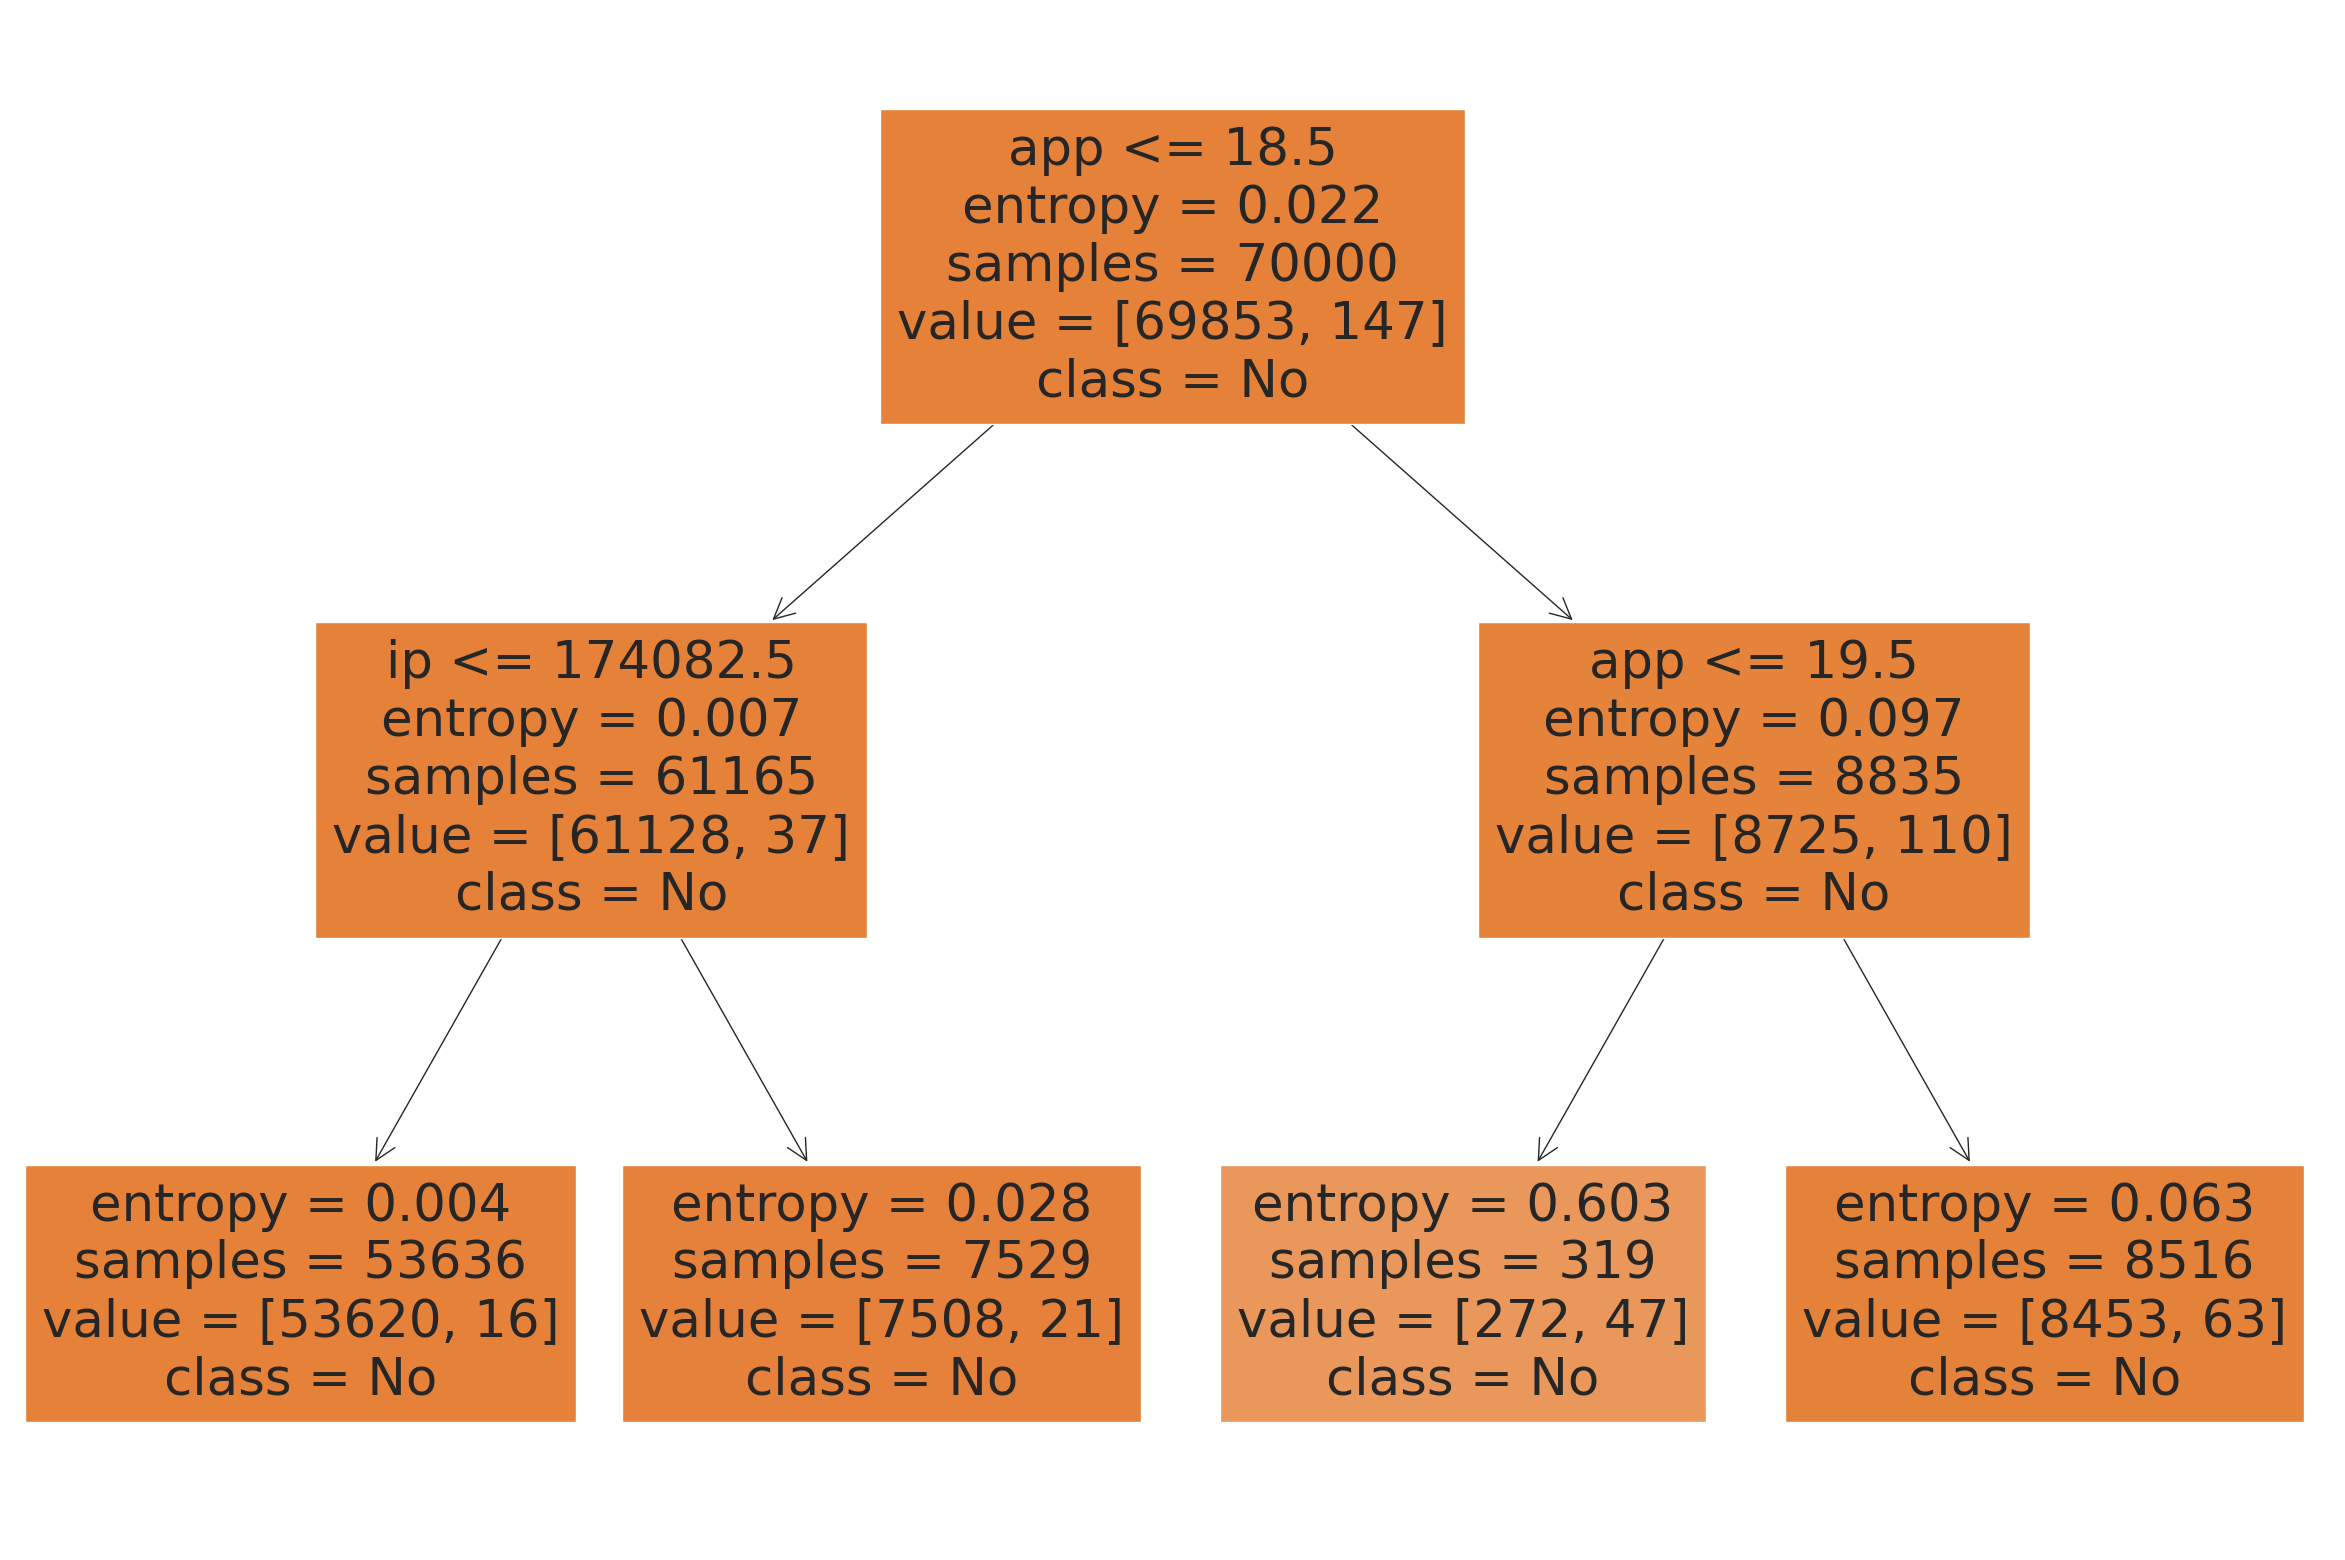

In [ ]:
# Plot the tree
fig=plt.figure(figsize=(30,20))
tree.plot_tree(model,feature_names=list(predictors_train.columns),class_names=['No','Yes'],filled=True)

In [ ]:
# Make predictions on training and testing data
prediction_on_train=model.predict(predictors_train)
prediction_on_test=model.predict(predictors_test)

In [ ]:
# Examine the evaluation results on training data: accuracy, precision, recall, and f1-score
print(classification_report(target_train,prediction_on_train))

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00     69853
           1       0.00      0.00      0.00       147

    accuracy                           1.00     70000
   macro avg       0.50      0.50      0.50     70000
weighted avg       1.00      1.00      1.00     70000



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# Examine the evaluation results on testing data: accuracy, precision, recall, and f1-score
print(classification_report(target_test,prediction_on_test))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     29920
           1       0.00      0.00      0.00        80

    accuracy                           1.00     30000
   macro avg       0.50      0.50      0.50     30000
weighted avg       0.99      1.00      1.00     30000



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
